# Bayesian Regression Using NumPyro

In this tutorial, we will explore how to do bayesian regression in NumPyro, using a simple example adapted from Statistical Rethinking [[1](#References)]. In particular, we would like to explore the following:

 - Write a simple model using the `sample` NumPyro primitive.
 - Run inference using MCMC in NumPyro, in particular, using the No U-Turn Sampler (NUTS) to get a posterior distribution over our regression parameters of interest.
 - Learn about utilities such as `initialize_model` that are useful for running HMC.
 - Learn how we can use effect-handlers in NumPyro to generate execution traces, condition on sample sites, seed models with RNG seeds, etc., and use this to implement various utilities that will be useful for MCMC. e.g. computing model log likelihood, generating empirical distribution over the posterior predictive, etc.

## Tutorial Outline:
1. [Dataset](#Dataset)
2. [Regression Model to Predict Divorce Rate](#Regression-Model-to-Predict-Divorce-Rate)
  - [Model-1: Predictor-Marriage Rate](#Model-1:-Predictor---Marriage-Rate)
    - [Posterior Distribution over the Regression Parameters](#Posterior-Distribution-over-the-Regression-Parameters)
    - [Posterior Predictive Distribution](#Posterior-Predictive-Distribution)
    - [Model Log Likelihood](#Model-Log-Likelihood)
  - [Model-2: Predictor-Median Age of Marriage](#Model-2:-Predictor---Median-Age-of-Marriage)
  - [Model-3: Predictor-Marriage Rate and Median Age of Marriage](Model-3:-Predictor---Marriage-Rate-and-Median-Age-of-Marriage)
  - [Divorce Rate Residuals by State](#Divorce-Rate-Residuals-by-State)
3. [Regression Model with Measurement Error](#Regression-Model-with-Measurement-Error)
  - [Effect of Incorporating Measurement Noise on Residuals](#Effect-of-Incorporating-Measurement-Noise-on-Residuals)
4. [References](#References)

In [2]:
%reset -s -f

In [3]:
import jax
import jax.numpy as np
from jax import random, vmap
from jax.config import config; config.update("jax_platform_name", "cpu")
from jax.scipy.special import logsumexp
import matplotlib
import matplotlib.pyplot as plt
import numpy as onp
import pandas as pd
import seaborn as sns

from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro.handlers import sample, seed, substitute, trace
from numpyro.hmc_util import initialize_model
from numpyro.mcmc import mcmc

%matplotlib inline
plt.style.use('bmh')
plt.rcParams.update({'font.size': 16,
                     'xtick.labelsize': 14,
                     'ytick.labelsize': 14,
                     'axes.titlesize': 'large', 
                     'axes.labelsize': 'medium'})

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
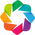

In [4]:
import holoviews as hv
# import 

hv.extension('bokeh') # important: doesn't render without it
hv.opts.defaults( hv.opts.Curve(width=800), hv.opts.Table(width= 800))

## Dataset

For this example, we will use the `WaffleDivorce` dataset from Chapter 05, Statistical Rethinking [[1](#References)]. The dataset contains divorce rates in each of the 50 states in the USA, along with predictors such as population, median age of marriage, whether it is a Southern state and, curiously, number of Waffle Houses.

In [5]:
DATASET_URL = 'https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/WaffleDivorce.csv'
dset = pd.read_csv(DATASET_URL, sep=';')
hv.Table(dset)

:Table   [Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860]

Let us plot the pair-wise relationship amongst the main variables in the dataset, using `seaborn.pairplot`. 

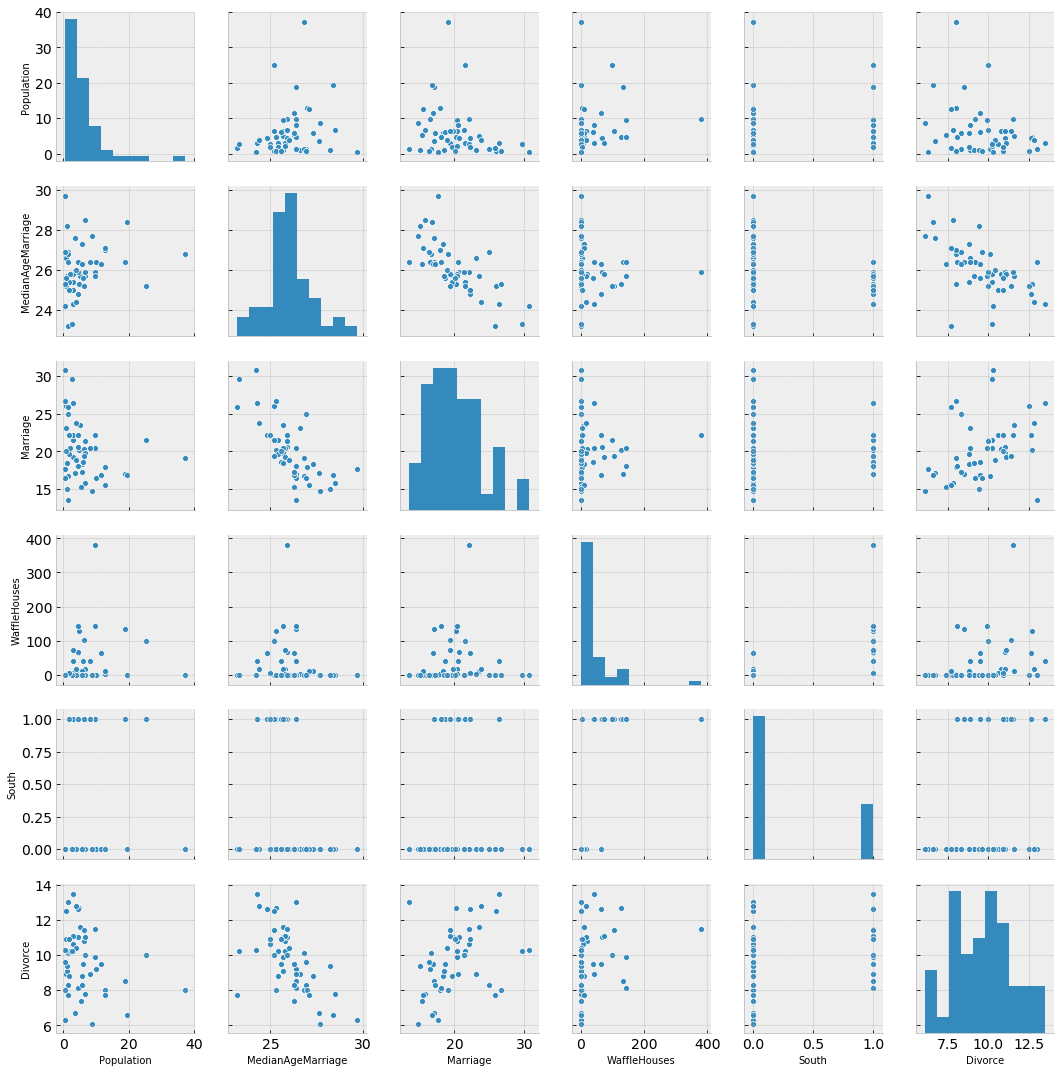

In [6]:
vars = ['Population', 'MedianAgeMarriage', 'Marriage', 'WaffleHouses', 'South', 'Divorce']
sns.pairplot(dset, x_vars=vars, y_vars=vars, palette='husl');

From the plots above, we can clearly observe that there is a relationship between divorce rates and marriage rates in a state (as might be expected), and also between divorce rates and median age of marriage. 

There is also a weak relationship between number of Waffle Houses and divorce rates, which is not obvious from the plot above, but will be clearer if we regress `Divorce` against `WaffleHouse` and plot the results. This is an example of a spurious association. We do not expect the number of Waffle Houses in a state to affect the divorce rate, but it is likely correlated with other factors that have an effect on the divorce rate. We will not delve into this spurious association in this tutorial, but the interested reader is encouraged to read Chapters 5 and 6 of [[1](#References)] which explores the problem of causal association in the presence of multiple predictors. 

For simplicity, we will primarily focus on marriage rate and the median age of marriage as our predictors for divorce rate throughout the remaining tutorial.

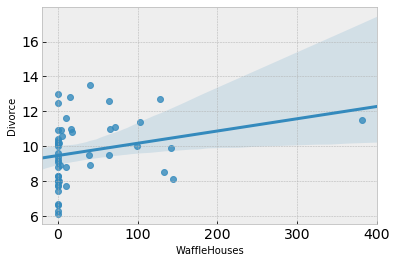

In [7]:
sns.regplot('WaffleHouses', 'Divorce', dset);

## Regression Model to Predict Divorce Rate

Let us now write a regressionn model in *NumPyro* to predict the divorce rate as a linear function of marriage rate and median age of marriage in each of the states. 

First, note that our predictor variables have somewhat different scales. It is a good practice to standardize our predictors and response variables to mean `0` and standard deviation `1`, which should result in faster inference. Refer to this [note](https://mc-stan.org/docs/2_19/stan-users-guide/standardizing-predictors-and-outputs.html) in the Stan manual for more details.

In [8]:
dset['AgeScaled'] = (dset.MedianAgeMarriage - onp.mean(dset.MedianAgeMarriage)) / onp.std(dset.MedianAgeMarriage)
dset['MarriageScaled'] = (dset.Marriage - onp.mean(dset.Marriage)) / onp.std(dset.Marriage)
dset['DivorceScaled'] = (dset.Divorce - onp.mean(dset.Divorce)) / onp.std(dset.Divorce)

We write the NumPyro model as follows. While the code should largely be self-explanatory, take note of the following:

 - In NumPyro, model code is any Python callable that can accept arguments and keywords. For HMC which we will be using for this tutorial, these arguments and keywords cannot change during model execution. This is convenient for passing in numpy arrays, or boolean arguments that might affect the execution path.
 - In addition to regular Python statements, the model code also contains primitives like `sample`. These primitives can be interpreted with various side-effects by effect handlers used by inference algorithms in NumPyro. For more on effect handlers, refer to [[3](#References)], [[4](#References)]. For now, just remember that a `sample` statement makes this a stochastic function by sampling from some distribution of interest.
 - The reason why we have kept our predictors as optional keyword arguments is to be able to reuse the same model as we vary the set of predictors. Likewise, the reason why the response variable is optional is that we would like to reuse this model to sample from the posterior predictive distribution. See the [section](#Posterior-Predictive-Distribution) on plotting the posterior predictive distribution, as an example.

In [9]:
def model(marriage=None, age=None, divorce=None):
    a = sample('a', dist.Normal(0., 0.2))
    M, A = 0., 0.
    if marriage is not None:
        bM = sample('bM', dist.Normal(0., 0.5))
        M = bM * marriage
    if age is not None:
        bA = sample('bA', dist.Normal(0., 0.5))
        A = bA * age
    sigma = sample('sigma', dist.Exponential(1.))
    mu = a + M + A
    sample('obs', dist.Normal(mu, sigma), obs=divorce)

### Model 1: Predictor - Marriage Rate

We first try to model the divorce rate as depending on a single variable, marriage rate. As mentioned above, we can use the same `model` code as earlier, but only pass values for `marriage` and `divorce` keyword arguments. We will use the No U-Turn Sampler (see [[5](#References)] for more details on the NUTS algorithm) to run inference on this simple model.


Note the following requirements for running HMC and NUTS in NumPyro:

 - The Hamiltonian Monte Carlo (or, the NUTS) implementation in Pyro takes in a potential energy function. This is the negative log joint density for the model. 
 - The verlet integrator in HMC (or, NUTS) returns sample values simulated using Hamiltonian dynamics in the unconstrained space. As such, continuous variables with bounded support need to be transformed into unconstrained space using bijective transforms. We also need to transform these samples back to their constrained support before returning these values to the user.
 
Thankfully, all of this is handled on the backend for us. Let us go through the steps one by one.

 - JAX uses functional PRNGs. Unlike other languages / frameworks which maintain a global random state, in JAX, every call to a sampler requires an [explicit PRNGKey](https://github.com/google/jax#random-numbers-are-different). We will split our initial random seed for subsequent operations, so that we do not accidentally reuse the same seed.
 - The function [initialize_model](https://numpyro.readthedocs.io/en/latest/mcmc.html#numpyro.hmc_util.initialize_model) takes a model along with model arguments (and keyword arguments), and returns a tuple of initial parameters, potential energy function, and constrain function. The initial parameters are used to initiate the MCMC chain, the potential energy function is a callable that when given unconstrained sample values returns the potential energy at these sample values. This is used by the verlet integrator in HMC. Lastly, `constrain_fn` is a callable that transforms the unconstrained samples returned by HMC/NUTS to sample values that lie within the constrained support.
 - Finally, we use the [mcmc](https://numpyro.readthedocs.io/en/latest/mcmc.html#numpyro.mcmc.mcmc) function to run inference using the default `NUTS` sampler. Note that to run vanilla HMC, all you need to do is to pass `algo='HMC'` as argument to `mcmc` instead. This is a convenience utility that does all of the following:

   - Runs warmup - adapts steps size and mass matrix.
   - Uses the sample from the warmup phase to start MCMC.
   - Return samples from the posterior distribution and print diagnostic information.

In [10]:
# Start from this source of randomness. We will split keys for subsequent operations.
rng = random.PRNGKey(0)
rng_, rng = random.split(rng)

# Initialize the model.
init_params, potential_fn, constrain_fn = initialize_model(rng_, model, 
                                                           marriage=dset.MarriageScaled.values, 
                                                           divorce=dset.DivorceScaled.values)
num_warmup, num_samples = 1000, 2000

# Run NUTS.
samples_1 = mcmc(num_warmup, num_samples, init_params,
                 potential_fn=potential_fn, 
                 trajectory_length=10, 
                 constrain_fn=constrain_fn)

sample: 100%|██████████| 2000/2000 [00:02<00:00, 916.73it/s, 3 steps of size 6.77e-01. acc. prob=0.88]




                           mean         sd       5.5%      94.5%      n_eff       Rhat
                   a      -0.00       0.11      -0.18       0.18    1189.06       1.00
                  bM       0.35       0.13       0.13       0.55    1143.98       1.00
               sigma       0.96       0.10       0.81       1.11    1237.53       1.00


#### Posterior Distribution over the Regression Parameters

We notice that the progress bar gives us online statistics on the acceptance probability, step size and number of steps taken per sample while running NUTS. In particular, during warmup, we adapt the step size and mass matrix to achieve a certain target acceptance probability (0.8, by default). We were able to successfully adapt our step size to achieve this target in the warmup phase.

During warmup, the aim is to adapt or learn values for hyper-parameters such as step size and mass matrix (the HMC algorithm is very sensitive to these hyper-parameters), and to reach the typical set (see [[6](#References)] for more details). If there are any issues in the model specification, it might be reflected in low acceptance probabilities or very high number of steps. We use the sample from the end of the warmup phase to seed the MCMC chain (denoted by the second `sample` progress bar) from which we generate the desired number of samples from our target distribution.

At the end of inference, NumPyro prints the mean, std and 90% CI values for each of the latent parameters. Note that since we standardized our predictors and response variable, we would expect the intercept to have mean 0, as can be seen here. It also prints other convergence diagnostics on the latent parameters in the model, including [effective sample size](https://numpyro.readthedocs.io/en/latest/diagnostics.html#numpyro.diagnostics.effective_sample_size) and the [gelman rubin diagnostic](https://numpyro.readthedocs.io/en/latest/diagnostics.html#numpyro.diagnostics.gelman_rubin) ($\hat{R}$). The value for these diagnostics indicates that the chain has converged to the target distribution. In our case, the "target distribution" is the posterior distribution over the latent parameters that we are interested in. Note that this is often worth verifying with multiple chains on more complicated models. In the end, `samples_1` is a collection (in our case, a `dict` since `init_samples` was a `dict`) containing samples from the posterior distribution for each of the latent parameters in the model.

To look at our regression fit, let us plot the regression line using our posterior estimates for the regression parameters, along with the 90% Credibility Interval (CI). Note that the [hpdi](https://numpyro.readthedocs.io/en/latest/diagnostics.html#numpyro.diagnostics.hpdi) function in NumPyro's diagnostics module can be used to compute CI. In the functions below, note that the collected samples from the posterior are all along the leading axis.

We can see from the plot, that the CI broadens towards the tails where values of the predictor variables are sparse, as can be expected.

In [12]:
def plot_regression(x, y_mean, y_hpdi):
    # Sort values for plotting by x axis
    idx = np.argsort(x)
    marriage = x[idx]
    mean = y_mean[idx]
    hpdi = y_hpdi[:, idx]
    divorce = dset.DivorceScaled.values[idx]

    # Plot
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    ax.plot(marriage, mean)
    ax.plot(marriage, divorce, 'o')
    ax.fill_between(marriage, hpdi[0], hpdi[1], alpha=0.3, interpolate=True)
    return ax

def hv_plot_regression(x, y_mean, y_hpdi, post_mu=None, draw_lines = True):
    # Sort values for plotting by x axis
    idx = np.argsort(x)
    marriage = x[idx]
    mean = y_mean[idx]
    hpdi = y_hpdi[:, idx]
    divorce = dset.DivorceScaled.values[idx]
    std_plot = (hv.Curve((marriage, mean)).opts(tools=['hover'], height=400) * 
        hv.Points((marriage, mean)).opts(tools=['hover'], size=4, color='orange') *
        hv.Scatter((marriage, divorce)).opts(color='red', size=4, tools=['hover']) * 
        hv.Area((marriage, hpdi[1,:],hpdi[0,:]), vdims=['l','u']).opts(alpha=0.3, tools=['hover']))
    final_plot = std_plot
#     if post_mu is not None:
#         post_plot = hv.Scatter( #### there's got to be an easier way ...
#         (x.reshape(1,-1).repeat(2000,axis=0).flatten(),
#          post_mu[:,:].flatten())).opts(size=1)
#     return (post_plot * std_plot) if (post_mu is not None) else std_plot
    if (post_mu is not None) and draw_lines:
        lines = hv.Overlay([hv.Curve((marriage, post_mu[i,idx])).opts(alpha=0.05, color='gray') for i in range(100)])
        dots = hv.Overlay([hv.Scatter((marriage,post_mu[i,idx])) for i in range(50)])
        final_plot = std_plot * lines * dots
    return final_plot

# Compute empirical posterior distribution over mu
posterior_mu = np.expand_dims(samples_1['a'], -1) + \
               np.expand_dims(samples_1['bM'], -1) * dset.MarriageScaled.values

mean_mu = np.mean(posterior_mu, axis=0)
hpdi_mu = hpdi(posterior_mu, 0.9)
# ax = plot_regression(dset.MarriageScaled.values, mean_mu, hpdi_mu)
# ax.set(xlabel='Marriage rate', ylabel='Divorce rate', title='Regression line with 90% CI');

hv_plot_regression(dset.MarriageScaled.values, mean_mu, hpdi_mu, posterior_mu)

:Overlay
   .Curve.I         :Curve   [x]   (y)
   .Points.I        :Points   [x,y]
   .Scatter.I       :Scatter   [x]   (y)
   .Area.I          :Area   [x]   (l,u)
   .Curve.II        :Curve   [x]   (y)
   .Curve.III       :Curve   [x]   (y)
   .Curve.IV        :Curve   [x]   (y)
   .Curve.V         :Curve   [x]   (y)
   .Curve.VI        :Curve   [x]   (y)
   .Curve.VII       :Curve   [x]   (y)
   .Curve.VIII      :Curve   [x]   (y)
   .Curve.IX        :Curve   [x]   (y)
   .Curve.X         :Curve   [x]   (y)
   .Curve.XI        :Curve   [x]   (y)
   .Curve.XII       :Curve   [x]   (y)
   .Curve.XIII      :Curve   [x]   (y)
   .Curve.XIV       :Curve   [x]   (y)
   .Curve.XV        :Curve   [x]   (y)
   .Curve.XVI       :Curve   [x]   (y)
   .Curve.XVII      :Curve   [x]   (y)
   .Curve.XVIII     :Curve   [x]   (y)
   .Curve.XIX       :Curve   [x]   (y)
   .Curve.XX        :Curve   [x]   (y)
   .Curve.XXI       :Curve   [x]   (y)
   .Curve.XXII      :Curve   [x]   (y)
   .Curve.XXIII     :Curve   [x]   (y)
   .Curve.XXIV      :Curve   [x]   (y)
   .Curve.XXV       :Curve   [x]   (y)
   .Curve.XXVI      :Curve   [x]   (y)
   .Curve.XXVII     :Curve   [x]   (y)
   .Curve.XXVIII    :Curve   [x]   (y)
   .Curve.XXIX      :Curve   [x]   (y)
   .Curve.XXX       :Curve   [x]   (y)
   .Curve.XXXI      :Curve   [x]   (y)
   .Curve.XXXII     :Curve   [x]   (y)
   .Curve.XXXIII    :Curve   [x]   (y)
   .Curve.XXXIV     :Curve   [x]   (y)
   .Curve.XXXV      :Curve   [x]   (y)
   .Curve.XXXVI     :Curve   [x]   (y)
   .Curve.XXXVII    :Curve   [x]   (y)
   .Curve.XXXVIII   :Curve   [x]   (y)
   .Curve.XXXIX     :Curve   [x]   (y)
   .Curve.XL        :Curve   [x]   (y)
   .Curve.XLI       :Curve   [x]   (y)
   .Curve.XLII      :Curve   [x]   (y)
   .Curve.XLIII     :Curve   [x]   (y)
   .Curve.XLIV      :Curve   [x]   (y)
   .Curve.XLV       :Curve   [x]   (y)
   .Curve.XLVI      :Curve   [x]   (y)
   .Curve.XLVII     :Curve   [x]   (y)
   .Curve.XLVIII    :Curve   [x]   (y)
   .Curve.XLIX      :Curve   [x]   (y)
   .Curve.L         :Curve   [x]   (y)
   .Curve.LI        :Curve   [x]   (y)
   .Curve.LII       :Curve   [x]   (y)
   .Curve.LIII      :Curve   [x]   (y)
   .Curve.LIV       :Curve   [x]   (y)
   .Curve.LV        :Curve   [x]   (y)
   .Curve.LVI       :Curve   [x]   (y)
   .Curve.LVII      :Curve   [x]   (y)
   .Curve.LVIII     :Curve   [x]   (y)
   .Curve.LIX       :Curve   [x]   (y)
   .Curve.LX        :Curve   [x]   (y)
   .Curve.LXI       :Curve   [x]   (y)
   .Curve.LXII      :Curve   [x]   (y)
   .Curve.LXIII     :Curve   [x]   (y)
   .Curve.LXIV      :Curve   [x]   (y)
   .Curve.LXV       :Curve   [x]   (y)
   .Curve.LXVI      :Curve   [x]   (y)
   .Curve.LXVII     :Curve   [x]   (y)
   .Curve.LXVIII    :Curve   [x]   (y)
   .Curve.LXIX      :Curve   [x]   (y)
   .Curve.LXX       :Curve   [x]   (y)
   .Curve.LXXI      :Curve   [x]   (y)
   .Curve.LXXII     :Curve   [x]   (y)
   .Curve.LXXIII    :Curve   [x]   (y)
   .Curve.LXXIV     :Curve   [x]   (y)
   .Curve.LXXV      :Curve   [x]   (y)
   .Curve.LXXVI     :Curve   [x]   (y)
   .Curve.LXXVII    :Curve   [x]   (y)
   .Curve.LXXVIII   :Curve   [x]   (y)
   .Curve.LXXIX     :Curve   [x]   (y)
   .Curve.LXXX      :Curve   [x]   (y)
   .Curve.LXXXI     :Curve   [x]   (y)
   .Curve.LXXXII    :Curve   [x]   (y)
   .Curve.LXXXIII   :Curve   [x]   (y)
   .Curve.LXXXIV    :Curve   [x]   (y)
   .Curve.LXXXV     :Curve   [x]   (y)
   .Curve.LXXXVI    :Curve   [x]   (y)
   .Curve.LXXXVII   :Curve   [x]   (y)
   .Curve.LXXXVIII  :Curve   [x]   (y)
   .Curve.LXXXIX    :Curve   [x]   (y)
   .Curve.XC        :Curve   [x]   (y)
   .Curve.XCI       :Curve   [x]   (y)
   .Curve.XCII      :Curve   [x]   (y)
   .Curve.XCIII     :Curve   [x]   (y)
   .Curve.XCIV      :Curve   [x]   (y)
   .Curve.XCV       :Curve   [x]   (y)
   .Curve.XCVI      :Curve   [x]   (y)
   .Curve.XCVII     :Curve   [x]   (y)
   .Curve.XCVIII    :Curve   [x]   (y)
   .Curve.XCIX      :Curve   [x]   (y)
   .Curve.C  

#### Posterior Predictive Distribution

Let us now look at the posterior predictive distribution to see how our predictive distribution looks with respect to the observed divorce rates. To get samples from the posterior predictive distribution, we need to run the model by substituting the latent parameters with samples from the posterior. This sounds complicated, but this can be easily achieved by using effect handlers from the [handlers module](https://numpyro.readthedocs.io/en/latest/handlers.html).

In particular, note the use of the `substitute`, `seed` and `trace` effect handlers in the `predict` function.

 - The `seed` effect-handler is used to wrap a stochastic function with an initial `PRNGKey` seed. When a sample statement inside the model is called, it uses the existing seed to sample from a distribution but this effect-handler also splits the existing key to ensure that future `sample` calls in the model use the newly split key instead. This is to prevent us from having to explicitly pass in a `PRNGKey` to each `sample` statement.
 - The `substitute` effect handler simply substitutes the value for the site name present in the `post_samples` dict instead of sampling from the distribution, which can be useful for conditioning sample sites to certain values.
 - The `trace` effect handler runs the model and records the execution trace within an `OrderedDict`. This trace object contains execution metadata that is useful for computing quantities such as the log joint density.
 
It should be clear now that the `predict` function simply runs the model by substituting the latent parameters with samples from the posterior (generated by the `mcmc` function) to generate predictions, which are samples from the posterior predictive distribution. Note the use of JAX's auto-vectorization transform called [vmap](https://github.com/google/jax#auto-vectorization-with-vmap) to vectorize predictions. If we didn't use `vmap`, we would have to use a native for loop which for each sample which is much slower. Each draw from the posterior can be used to get predictions over all the 50 states. When we vectorize this over all the samples from the posterior using `vmap`, we will get a `predictions_1` array of shape `(num_samples, 50)`. We can then compute the mean and 90% CI of these samples to plot the posterior predictive distribution.

# write it again and again.
## Grid Search

no. I've got one parameter $\mu$. and I've got a grid of values for $\mu$, say `np.linspace(0.05, 1.0, 20)`. But I'm going to give a _prior_ probability to these $\mu$, in this case, they'll all be the same so, $P(\mu_i)=1/20$ for all $i$. 

In [48]:
from IPython.display import Math, Markdown

In [125]:
mu_grid = np.linspace(0.05, 1.0, 20)
def prob_mu(mu): return np.ones_like(mu) * 1/20.0
data = np.array([0.2, 0.84, 0.11, 0.523])
def prob_data(d, mu):
    return np.exp(dist.Normal(loc=mu, scale=1.0).log_prob(d))
def post_prob(mu_a, d_a):
    # if mu_a.shape = (3,)
    # d_a.shape = (2,)
    # then p_grid.shape == (3, 2)
    p_grid = prob_data(d_a.broadcast((1,)).T,  mu_a)
    print (p_grid.shape, (mu_a.shape, d_a.shape))
    assert ( p_grid.shape == (d_a.shape[0], mu_a.shape[0]))
    p_evidence = p_grid.sum(axis= 1)
    assert ( p_evidence.shape == d_a.shape )
    print( (p_grid * prob_mu(mu_a)).shape )
    print( p_evidence.broadcast(mu_a.shape).shape)
    res =  p_grid * prob_mu(mu_a) / p_evidence.broadcast(mu_a.shape).T
    return res

%precision 5
# display( prob_data(2.0,1.0))
# display( prob_data(data,1.0))
# display( prob_data(np.expand_dims(data, axis=1), mu_grid))
max_mu_idx = prob_data(np.expand_dims(data, axis=1), mu_grid).argmax(axis=1)
# necessary to make indexing work properly
max_mu_idx_a = onp.asarray(max_mu_idx)
display(Markdown(rf"""
max $\mu$ index for {data},{max_mu_idx},  
$\mu$ values {mu_grid[max_mu_idx_a]}
$\mu$ probabilities for $x=0.84$

"""))
display([(p.item(),q) for p,q in zip(post_prob(mu_grid, data)[1], mu_grid)])
hv.Scatter((mu_grid, post_prob(mu_grid, data)[1]), kdims=['mu','prob']) * hv.VLine(0.85)


max $\mu$ index for [0.2   0.84  0.11  0.523],[ 3 16  1  9],  
$\mu$ values [0.2  0.85 0.1  0.5 ]
$\mu$ probabilities for $x=0.84$



(4, 20) ((20,), (4,))
(4, 20)
(20, 4)


[(0.00200, 0.05),
 (0.00207, 0.1),
 (0.00215, 0.15),
 (0.00222, 0.2),
 (0.00229, 0.25),
 (0.00236, 0.3),
 (0.00242, 0.35),
 (0.00247, 0.39999999999999997),
 (0.00253, 0.44999999999999996),
 (0.00257, 0.49999999999999994),
 (0.00261, 0.5499999999999999),
 (0.00265, 0.6),
 (0.00268, 0.65),
 (0.00270, 0.7),
 (0.00271, 0.75),
 (0.00272, 0.7999999999999999),
 (0.00273, 0.85),
 (0.00272, 0.9),
 (0.00271, 0.95),
 (0.00269, 1.0)]

(4, 20) ((20,), (4,))
(4, 20)
(20, 4)


:Overlay
   .Scatter.I :Scatter   [mu,prob]   (y)
   .VLine.I   :VLine   [x,y]

Now I've got a woof a data, say, `[0.2, 0.4, 0.11]`. What I first want to know is what is the likelihood of each $\mu_i$ given this data. Well, that is given by $P(0.2 | \mu=0.0) \times P(0.4 | \mu=0.0) \times \ldots P(0.11 | \mu=0.0)$, we'll call this $L(\mu=0.0 | D)$. But is _not_ the posterior distribution, not yet. The _posterior distribution_, which is the golden egg of this whole thing is the probabibility of $\mu_i$ given the data $D$ _and_ the _prior_ distribution of $\mu$. (and then we have to normalize the whole thing). 

To normalize this all we have to do is divide $P(D | \mu=0.1)\times P(\mu=0.1)$ by $\sum_i L( D | \mu_i )$

The result is $$P(\mu = 0.1 | D) = \frac{P(D | \mu=0.1)\times P(\mu=0.1)}{\sum_i P(D | \mu_i)}$$

you make a model, which is a bunch of related sample statement which have _a priori_ parameterized distributions. 
eg 
perceived_temp(avg for this day of the year) = Normal(temp, sigma)
sigma = Exp(10)
temp = 10*is_sunny + (-5)*is_windy + (-10)*is_rainy + avg_for_this_day_of_the_year
is_sunny = Bin(0.6)
is_windy = Exp(0.1)
is_rainy = Bin(0.1)

perceived_temp is a stochastic function because we don't know what it has the stochastic functions is_windy etc in it.. 

if we replaced the co-effs for is_sunny, is_rainy, is_windy with parameters then this could be a regression problem. 

you have some data which corresponds to a subset of these sample statements. you _run_ your model on this data. what does that mean? it means you sample from each of the _a priori_ distributions 

In [14]:
def predict(rng, post_samples, model, *args, **kwargs):
    ## model gets modified to replace named distributions with generated samples
    model = substitute(seed(model, rng), post_samples)
 
    ## this code is very similar to lines 42.. in rethinking.py
    model_trace = trace(model).get_trace(*args, **kwargs)
    return model_trace['obs']['value']

In [15]:
# vectorize predictions via vmap
predict_fn = vmap(lambda rng, samples: 
                  predict(rng, samples, model, marriage=dset.MarriageScaled.values))
rng, rng_ = random.split(rng)
predictions_1 = predict_fn(random.split(rng_, num_samples), samples_1)

mean_pred = np.mean(predictions_1, axis=0)
hpdi_pred = hpdi(predictions_1, 0.9)

hv_plot_regression(dset.MarriageScaled.values, mean_pred, hpdi_pred).opts(
    title='Predictions with 90% CI',
    xlabel='Marriage rate', ylabel='Divorce rate') 
# ax = plot_regression(dset.MarriageScaled.values, mean_pred, hpdi_pred)
# ax.set(xlabel='Marriage rate', ylabel='Divorce rate', title='Predictions with 90% CI');

:Overlay
   .Curve.I   :Curve   [x]   (y)
   .Points.I  :Points   [x,y]
   .Scatter.I :Scatter   [x]   (y)
   .Area.I    :Area   [x]   (l,u)

We will use the same `plot_regression` function as earlier. We notice that our CI for the predictive distribution is much broader as compared to the last plot due to the additional noise introduced by the `sigma` parameter. Note that most data points lie well within the 90% CI, which indicates a good fit.

#### Model Log Likelihood

Likewise, making use of effect-handlers and `vmap`, we can also compute the log likelihood for this model given the dataset.

In [12]:
def log_lk(rng, params, model, *args, **kwargs):
    model = substitute(seed(model, rng), params)
    model_trace = trace(model).get_trace(*args, **kwargs)
    obs_node = model_trace['obs']
    return np.sum(obs_node['fn'].log_prob(obs_node['value']))
    
def expected_log_likelihood(rng, params, model, *args, **kwargs):
    n = list(params.values())[0].shape[0]
    log_lk_fn = vmap(lambda rng, params: log_lk(rng, params, model, *args, **kwargs))
    log_lk_vals = log_lk_fn(random.split(rng, n), params)
    return logsumexp(log_lk_vals) - np.log(n)

In [13]:
rng, rng_ = random.split(rng)
print('Log likelihood: {}'.format(expected_log_likelihood(rng_,
                                                          samples_1, 
                                                          model,
                                                          marriage=dset.MarriageScaled.values,
                                                          divorce=dset.DivorceScaled.values)))

Log likelihood: -68.14618682861328


### Model 2: Predictor - Median Age of Marriage

We will now model the divorce rate as a function of the median age of marriage. The computations are mostly a reproduction of what we did for Model 1. Notice the following:

 - Divorce rate is inversely related to the age of marriage. Hence states where the median age of marriage is low will likely have a higher divorce rate.
 - We get a higher log likelihood of -60.92 as compared to -68.15 with Model 2, indicating that median age of marriage is likely a much better predictor of divorce rate. 

In [14]:
rng, rng_ = random.split(rng)
init_params, potential_fn, constrain_fn = initialize_model(rng_, model, 
                                                           age=dset.AgeScaled.values, 
                                                           divorce=dset.DivorceScaled.values)

samples_2 = mcmc(num_warmup, num_samples, init_params,
                 potential_fn=potential_fn, 
                 trajectory_length=10, 
                 constrain_fn=constrain_fn)

sample: 100%|██████████| 2000/2000 [00:04<00:00, 470.51it/s, 3 steps of size 6.96e-01. acc. prob=0.88]




                           mean         sd       5.5%      94.5%      n_eff       Rhat
                   a      -0.00       0.10      -0.17       0.16    1036.93       1.00
                  bA      -0.57       0.11      -0.75      -0.39    1246.97       1.00
               sigma       0.83       0.09       0.71       0.97    1195.21       1.00


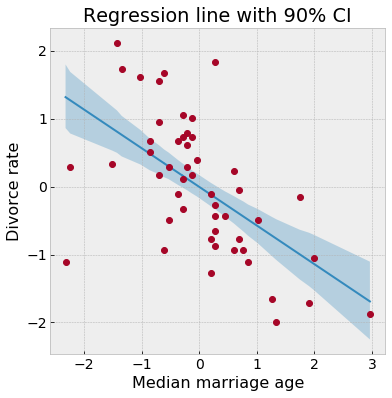

In [15]:
posterior_mu = np.expand_dims(samples_2['a'], -1) + \
               np.expand_dims(samples_2['bA'], -1) * dset.AgeScaled.values
mean_mu = np.mean(posterior_mu, axis=0)
hpdi_mu = hpdi(posterior_mu, 0.9)
ax = plot_regression(dset.AgeScaled.values, mean_mu, hpdi_mu)
ax.set(xlabel='Median marriage age', ylabel='Divorce rate', title='Regression line with 90% CI');

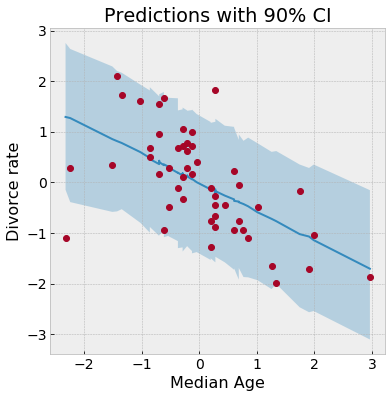

In [16]:
rng, rng_ = random.split(rng)
predict_fn = vmap(lambda rng, samples: predict(rng, samples, model, age=dset.AgeScaled.values))
predictions_2 = predict_fn(random.split(rng_, num_samples), samples_2)

mean_pred = np.mean(predictions_2, axis=0)
hpdi_pred = hpdi(predictions_2, 0.9)

ax = plot_regression(dset.AgeScaled.values, mean_pred, hpdi_pred)
ax.set(xlabel='Median Age', ylabel='Divorce rate', title='Predictions with 90% CI');

In [17]:
rng, rng_ = random.split(rng)
print('Log likelihood: {}'.format(expected_log_likelihood(rng_,
                                                          samples_2, 
                                                          model,
                                                          age=dset.AgeScaled.values,
                                                          divorce=dset.DivorceScaled.values)))

Log likelihood: -60.926387786865234


### Model 3: Predictor - Marriage Rate and Median Age of Marriage

Finally, we will also model divorce rate as depending on both marriage rate as well as the median age of marriage. Note that there is no increase in the model's log likelihood over Model 2 which likely indicates that the marginal information from marriage rate in predicting divorce rate is low when the median age of marriage is already known.

In [18]:
rng, rng_ = random.split(rng)
init_params, potential_fn, constrain_fn = initialize_model(rng_, model, 
                                                           marriage=dset.MarriageScaled.values,
                                                           age=dset.AgeScaled.values,
                                                           divorce=dset.DivorceScaled.values)

samples_3 = mcmc(num_warmup, num_samples, init_params,
                 potential_fn=potential_fn, 
                 trajectory_length=10, 
                 constrain_fn=constrain_fn)

sample: 100%|██████████| 2000/2000 [00:04<00:00, 474.30it/s, 3 steps of size 6.48e-01. acc. prob=0.86]




                           mean         sd       5.5%      94.5%      n_eff       Rhat
                   a       0.00       0.10      -0.15       0.18     959.98       1.00
                  bA      -0.61       0.16      -0.89      -0.38     981.45       1.00
                  bM      -0.06       0.16      -0.30       0.19     961.60       1.00
               sigma       0.84       0.09       0.70       0.97     930.44       1.00


In [19]:
rng, rng_ = random.split(rng)
print('Log likelihood: {}'.format(expected_log_likelihood(rng_,
                                                          samples_3,
                                                          model,
                                                          marriage=dset.MarriageScaled.values,
                                                          age=dset.AgeScaled.values,
                                                          divorce=dset.DivorceScaled.values)))

Log likelihood: -61.04328918457031


### Divorce Rate Residuals by State

The regression plots above shows that the observed divorce rates for many states differs considerably from the mean regression line. To dig deeper into how the last model (Model 3) under-predicts or over-predicts for each of the states, we will plot the posterior predictive and residuals (`Observed divorce rate - Predicted divorce rate`) for each of the states.

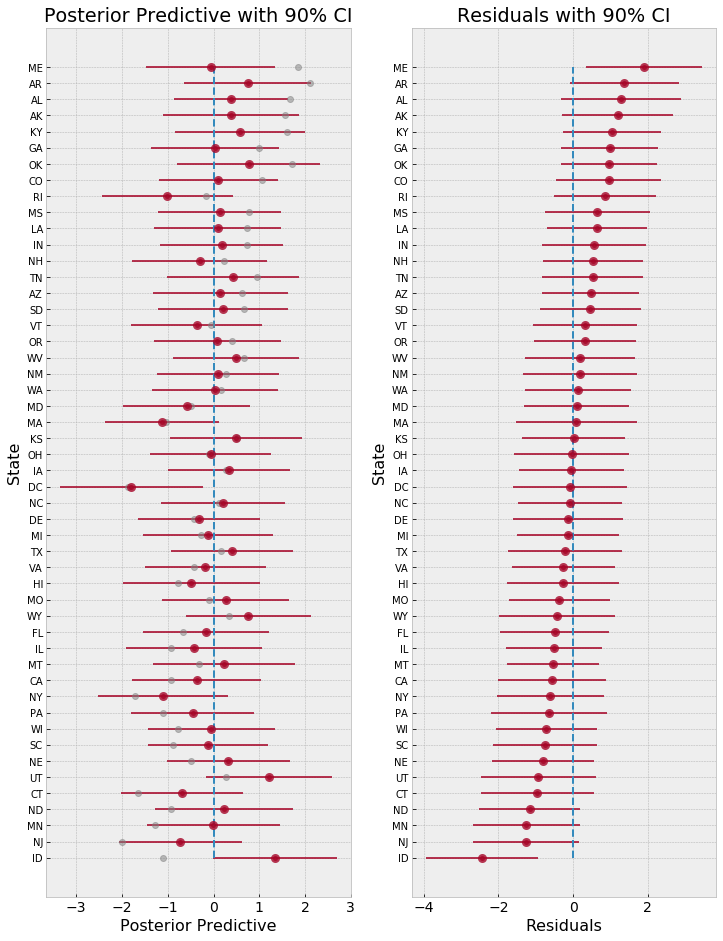

In [20]:
# Predictions for Model 3.
rng, rng_ = random.split(rng)
predict_fn = vmap(lambda rng, samples: predict(rng, samples, model,
                                               marriage=dset.MarriageScaled.values,
                                               age=dset.AgeScaled.values))
predictions_3 = predict_fn(random.split(rng_, num_samples), samples_3)
y = np.arange(50)


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 16))
pred_mean = np.mean(predictions_3, axis=0)
pred_hpdi = hpdi(predictions_3, 0.9)
residuals_3 = dset.DivorceScaled.values - predictions_3
residuals_mean = np.mean(residuals_3, axis=0)
residuals_hpdi = hpdi(residuals_3, 0.9)
idx = np.argsort(residuals_mean)

# Plot posterior predictive
ax[0].plot(np.zeros(50), y, '--')
ax[0].errorbar(pred_mean[idx], y, xerr=pred_hpdi[1, idx] - pred_mean[idx], 
               marker='o', ms=5, mew=4, ls='none', alpha=0.8)
ax[0].plot(dset.DivorceScaled.values[idx], y, marker='o', 
           ls='none', color='gray', alpha=0.5)
ax[0].set(xlabel='Posterior Predictive', ylabel='State', title='Posterior Predictive with 90% CI')
ax[0].set_yticks(y)
ax[0].set_yticklabels(dset.Loc.values[idx], fontsize=10);

# Plot residuals
residuals_3 = dset.DivorceScaled.values - predictions_3
residuals_mean = np.mean(residuals_3, axis=0)
residuals_hpdi = hpdi(residuals_3, 0.9)
err = residuals_hpdi[1] - residuals_mean

ax[1].plot(np.zeros(50), y, '--')
ax[1].errorbar(residuals_mean[idx], y, xerr=err[idx], 
               marker='o', ms=5, mew=4, ls='none', alpha=0.8)
ax[1].set(xlabel='Residuals', ylabel='State', title='Residuals with 90% CI')
ax[1].set_yticks(y)
ax[1].set_yticklabels(dset.Loc.values[idx], fontsize=10);

The plot on the left shows the mean predictions with 90% CI for each of the states using Model 3. The gray markers indicate the actual observed divorce rates. The right plot shows the residuals for each of the states, and both these plots are sorted by the residuals, i.e. at the bottom, we are looking at states where the model predictions are higher than the observed rates, whereas at the top, the reverse is true.

Overall, the model fit seems good because most observed data points like within a 90% CI around the mean predictions.  However, notice how the model over-predicts by a large margin for states like Idaho (bottom left), and on the other end under-predicts for states like Maine (top right). This is likely indicative of other factors that we are missing out in our model that affect divorce rate across different states. Even ignoring other socio-political variables, one such factor that we have not yet modeled is the measurement noise given by `Divorce SE` in the dataset. We will explore this in the next section.

## Regression Model with Measurement Error

Note that in our previous models, each data point influences the regression line equally. Is this well justified? We will build on the previous model to incorporate measurement error given by `Divorce SE` variable in the dataset. Incorporating measurement noise will be useful in ensuring that observations that have higher confidence (i.e. lower measurement noise) have a greater impact on the regression line. On the other hand, this will also help us better model outliers with high measurement errors. For more details on modeling errors due to measurement noise, refer to Chapter 15 of [[1](#References)].

To do this, we will reuse Model 3, with the only change that the final observed value has a measurement error given by `divorce_sd` (notice that this has to be standardized since the `divorce` variable itself has been standardized to mean 0 and std 1).

In [21]:
def model_se(marriage, age, divorce_sd, divorce=None):
    a = sample('a', dist.Normal(0., 0.2))
    bM = sample('bM', dist.Normal(0., 0.5))
    M = bM * marriage
    bA = sample('bA', dist.Normal(0., 0.5))
    A = bA * age
    sigma = sample('sigma', dist.Exponential(1.))
    mu = a + M + A
    divorce_rate = sample('divorce_rate', dist.Normal(mu, sigma))
    sample('obs', dist.Normal(divorce_rate, divorce_sd), obs=divorce)

In [22]:
rng, rng_ = random.split(rng)
# Standardize
dset['DivorceScaledSD'] = dset['Divorce SE'] / np.std(dset.Divorce.values)
init_params, potential_fn, constrain_fn = initialize_model(rng_, model_se, 
                                                           marriage=dset.MarriageScaled.values,
                                                           age=dset.AgeScaled.values,
                                                           divorce_sd=dset.DivorceScaledSD.values,
                                                           divorce=dset.DivorceScaled.values)

In [23]:
samples_4 = mcmc(num_warmup=1000, 
                 num_samples=3000, 
                 init_params=init_params,
                 potential_fn=potential_fn,
                 trajectory_length=10,
                 target_accept_prob=0.9,
                 constrain_fn=constrain_fn)

sample: 100%|██████████| 3000/3000 [00:06<00:00, 442.19it/s, 15 steps of size 2.16e-01. acc. prob=0.94]




                           mean         sd       5.5%      94.5%      n_eff       Rhat
                   a      -0.05       0.09      -0.20       0.09    2038.60       1.00
                  bA      -0.61       0.16      -0.86      -0.36    1304.97       1.00
                  bM       0.06       0.17      -0.21       0.32    1202.76       1.00
     divorce_rate[0]       1.18       0.37       0.61       1.78    2914.40       1.00
     divorce_rate[1]       0.69       0.56      -0.18       1.61    3036.44       1.00
     divorce_rate[2]       0.44       0.34      -0.09       0.99    2751.97       1.00
     divorce_rate[3]       1.43       0.47       0.72       2.19    2636.39       1.00
     divorce_rate[4]      -0.91       0.13      -1.10      -0.69    3694.98       1.00
     divorce_rate[5]       0.66       0.39       0.03       1.29    2417.58       1.00
     divorce_rate[6]      -1.38       0.36      -1.91      -0.78    2419.38       1.00
     divorce_rate[7]      -0.34       0.4

### Effect of Incorporating Measurement Noise on Residuals

Notice that our values for the regression coefficients is very similar to Model 3. However, introducing measurement noise allows us to more closely match our predictive distributions to the observed values. We can see this if we plot the residuals as earlier. 

In [24]:
rng, rng_ = random.split(rng)
predict_fn = vmap(lambda rng, samples: predict(rng, samples, model_se, 
                                               marriage=dset.MarriageScaled.values,
                                               age=dset.AgeScaled.values,
                                               divorce_sd=dset.DivorceScaledSD.values))
predictions_4 = predict_fn(random.split(rng_, 3000), samples_4)

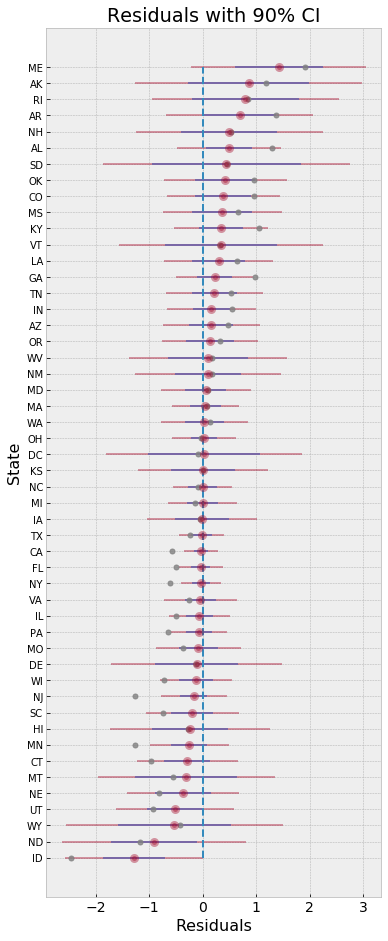

In [25]:
sd = dset.DivorceScaledSD.values
residuals_4 = dset.DivorceScaled.values - predictions_4
residuals_mean = np.mean(residuals_4, axis=0)
residuals_hpdi = hpdi(residuals_4, 0.9)
err = residuals_hpdi[1] - residuals_mean
idx = np.argsort(residuals_mean)
y = np.arange(50)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 16))


# Plot Residuals
ax.plot(np.zeros(50), y, '--')
ax.errorbar(residuals_mean[idx], y, xerr=err[idx], 
            marker='o', ms=5, mew=4, ls='none', alpha=0.4)

# Plot SD 
ax.errorbar(residuals_mean[idx], y, xerr=sd[idx], 
            ls='none')

# Plot earlier mean residual
ax.plot(np.mean(dset.DivorceScaled.values - predictions_3, 0)[idx], y,
        ls='none', marker='o', ms=5, color='gray', alpha=0.8)

ax.set(xlabel='Residuals', ylabel='State', title='Residuals with 90% CI')
ax.set_yticks(y)
ax.set_yticklabels(dset.Loc.values[idx], fontsize=10);

The plot above shows the residuals for each of the states, along with the measurement noise given by inner error bar. The gray dots are the mean residuals from our earlier Model 3. Notice how having an additional degree of freedom to model the measurement noise has shrunk the residuals. In particular, for Idaho and Maine, our predictions are now much closer to the observed values after incorporating measurement noise in the model.

To better see how measurement noise affects the movement of the regression line, let us plot the residuals with respect to the measurement noise.

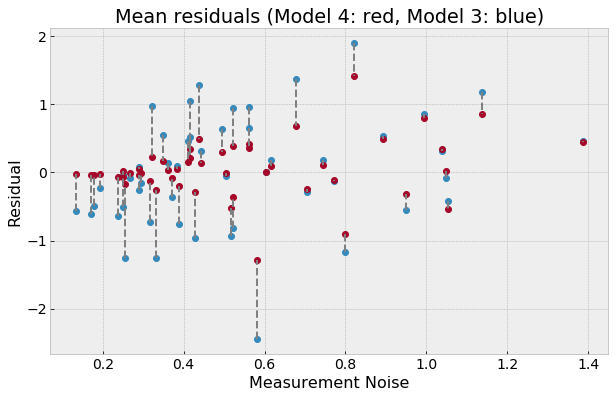

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
x = dset.DivorceScaledSD.values
y1 = np.mean(residuals_3, 0)
y2 = np.mean(residuals_4, 0)
ax.plot(x, y1, ls='none', marker='o')
ax.plot(x, y2, ls='none', marker='o')
for i, (j, k)  in enumerate(zip(y1, y2)):
    ax.plot([x[i], x[i]], [j, k], '--', color='gray');

ax.set(xlabel='Measurement Noise', ylabel='Residual', title='Mean residuals (Model 4: red, Model 3: blue)');

The plot above shows what has happend in more detail - the regression line itself has moved to ensure a better fit for observations with low measurement noise (left of the plot) where the residuals have shrunk very close to 0. That is to say that data points with low measurement error have a concomitantly higher contribution in determining the regression line. On the other hand, for states with high measurement error (right of the plot), incorporating measurement noise allows us to move our posterior distribution mass closer to the observations resulting in a shrinkage of residuals as well.

## References

1. McElreath, R. (2016). Statistical Rethinking: A Bayesian Course with Examples in R and Stan CRC Press.
2. Stan Development Team. [Stan User's Guide](https://mc-stan.org/docs/2_19/stan-users-guide/index.html)
3. Goodman, N.D., and StuhlMueller, A. (2014). [The Design and Implementation of Probabilistic Programming Languages](http://dippl.org/)
4. Pyro Development Team. [Poutine: A Guide to Programming with Effect Handlers in Pyro](http://pyro.ai/examples/effect_handlers.html)
5. Hoffman, M.D., Gelman, A. (2011). The No-U-Turn Sampler: Adaptively Setting Path Lengths in Hamiltonian Monte Carlo.
6. Betancourt, M. (2017). A Conceptual Introduction to Hamiltonian Monte Carlo.
7. JAX Development Team (2018). [Composable transformations of Python+NumPy programs: differentiate, vectorize, JIT to GPU/TPU, and more](https://github.com/google/jax)